In [466]:
# libs

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyod.models.knn import KNN

In [467]:
# Dataset

data = pd.read_csv('houses_to_rent.csv')
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [468]:
print(f"O DataFrame possui {data.shape[0]} registros e {data.shape[1]} colunas.")

O DataFrame possui 10692 registros e 13 colunas.


In [469]:
# visualizando as colunas

data.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [470]:
# renomeando as colunas

data.rename(columns={'hoa (R$)':'hoa', 'rent amount (R$)':'rent',
       'property tax (R$)': 'property_tax', 'fire insurance (R$)':'fire_insurance', 'total (R$)':'total'}, inplace=True)

In [471]:
data.dtypes

city              object
area               int64
rooms              int64
bathroom           int64
parking spaces     int64
floor             object
animal            object
furniture         object
hoa                int64
rent               int64
property_tax       int64
fire_insurance     int64
total              int64
dtype: object

In [472]:
# transformando algumas colunas em string

selecionados = ['area', 'rooms', 'bathroom', 'parking spaces']

for coluna in selecionados:
    data[coluna] = data[coluna].astype(str)

In [473]:
data.dtypes

city              object
area              object
rooms             object
bathroom          object
parking spaces    object
floor             object
animal            object
furniture         object
hoa                int64
rent               int64
property_tax       int64
fire_insurance     int64
total              int64
dtype: object

In [474]:
# visualizando dados nulos

data.isnull().sum()

print("Não há ocorrencia de dados nulos")

Não há ocorrencia de dados nulos


In [475]:
# verificando dados duplicados

data.duplicated().sum()

358

In [476]:
# removendo dados duplicados

data.drop_duplicates(inplace=True)

In [477]:
# verificando a remoção de duplicados

data.duplicated().sum()

0

In [478]:
# após a remoção dos dados duplicados

data.shape

(10334, 13)

In [479]:
# cidades

data["city"].value_counts()

São Paulo         5717
Rio de Janeiro    1431
Belo Horizonte    1209
Porto Alegre      1154
Campinas           823
Name: city, dtype: int64

<AxesSubplot:xlabel='city', ylabel='count'>

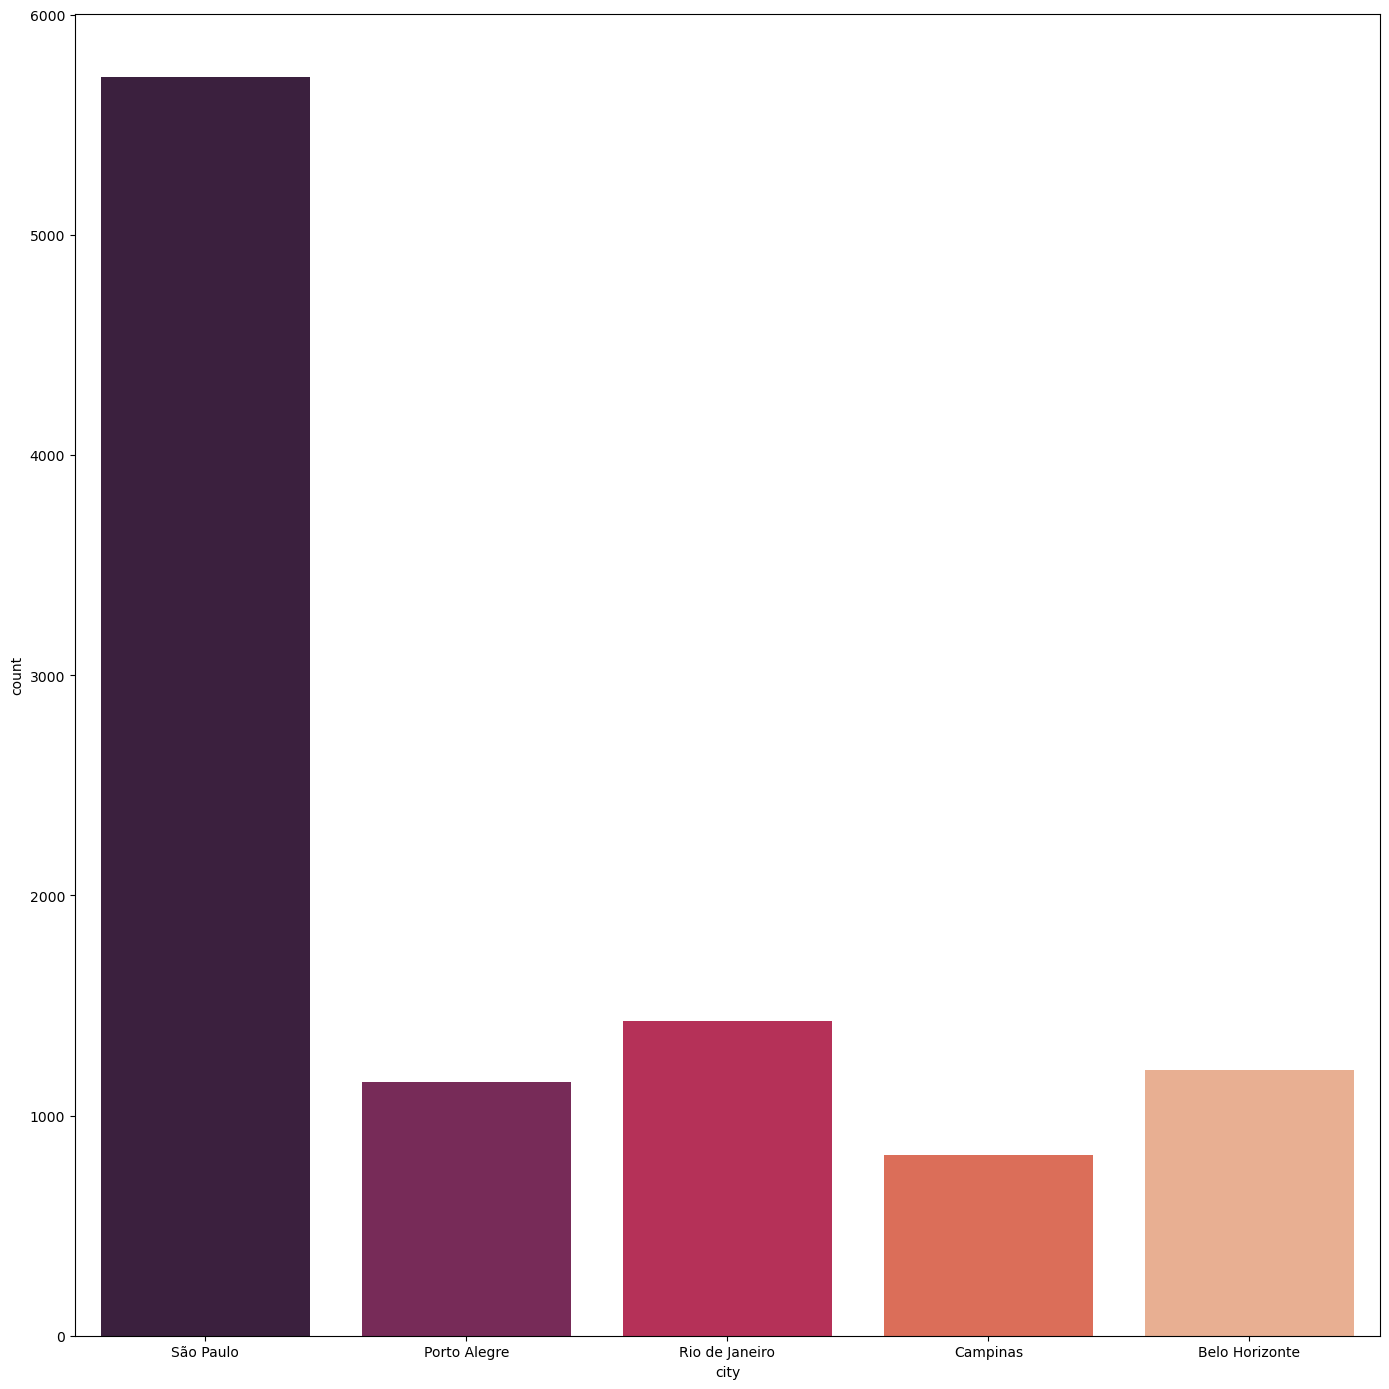

In [480]:
# numero de casas para alugar por cidade

sns.countplot(data=data, x=data['city'], palette="rocket")

## Identificando outliers

In [481]:
# removendo a variavel target
df = data.iloc[:,8:14]
df.head()

,hoa,rent,property_tax,fire_insurance,total
0,2065,3300,211,42,5618
1,1200,4960,1750,63,7973
2,1000,2800,0,41,3841
3,270,1112,22,17,1421
4,0,800,25,11,836


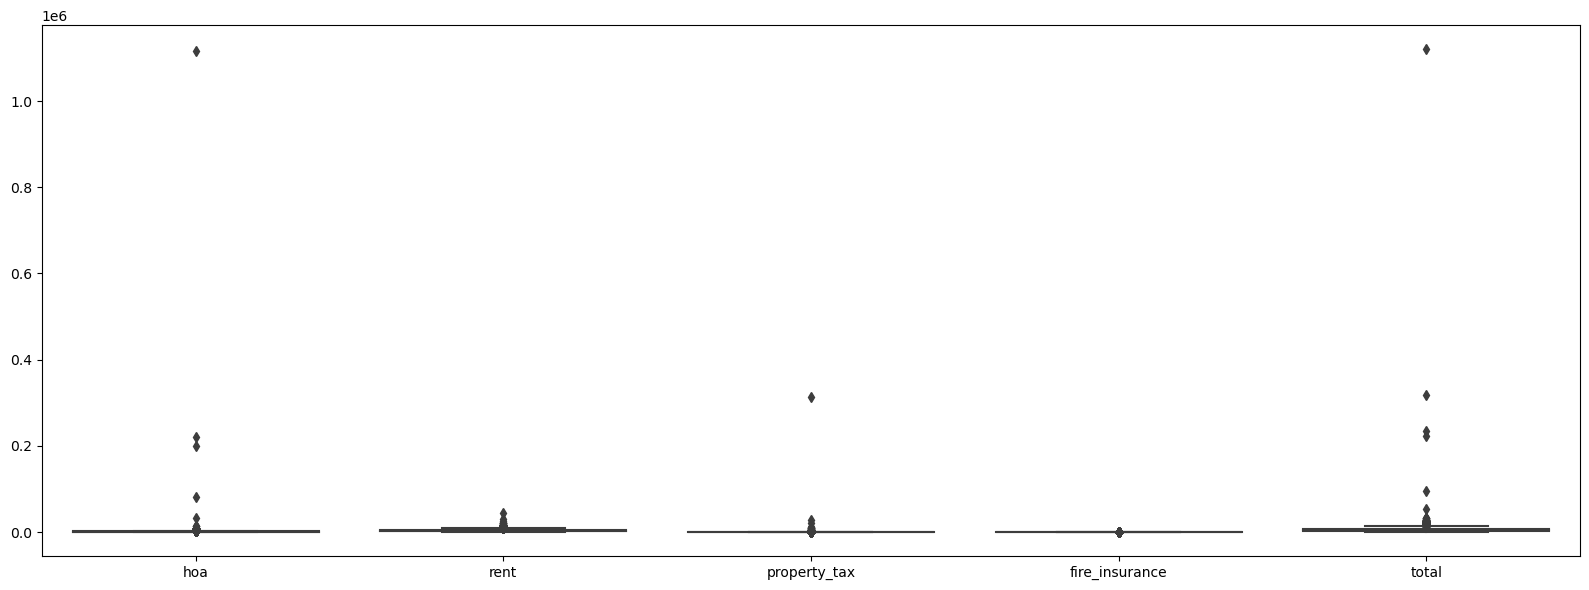

In [482]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data = df)

hoa : int64
rent : int64
property_tax : int64
fire_insurance : int64
total : int64


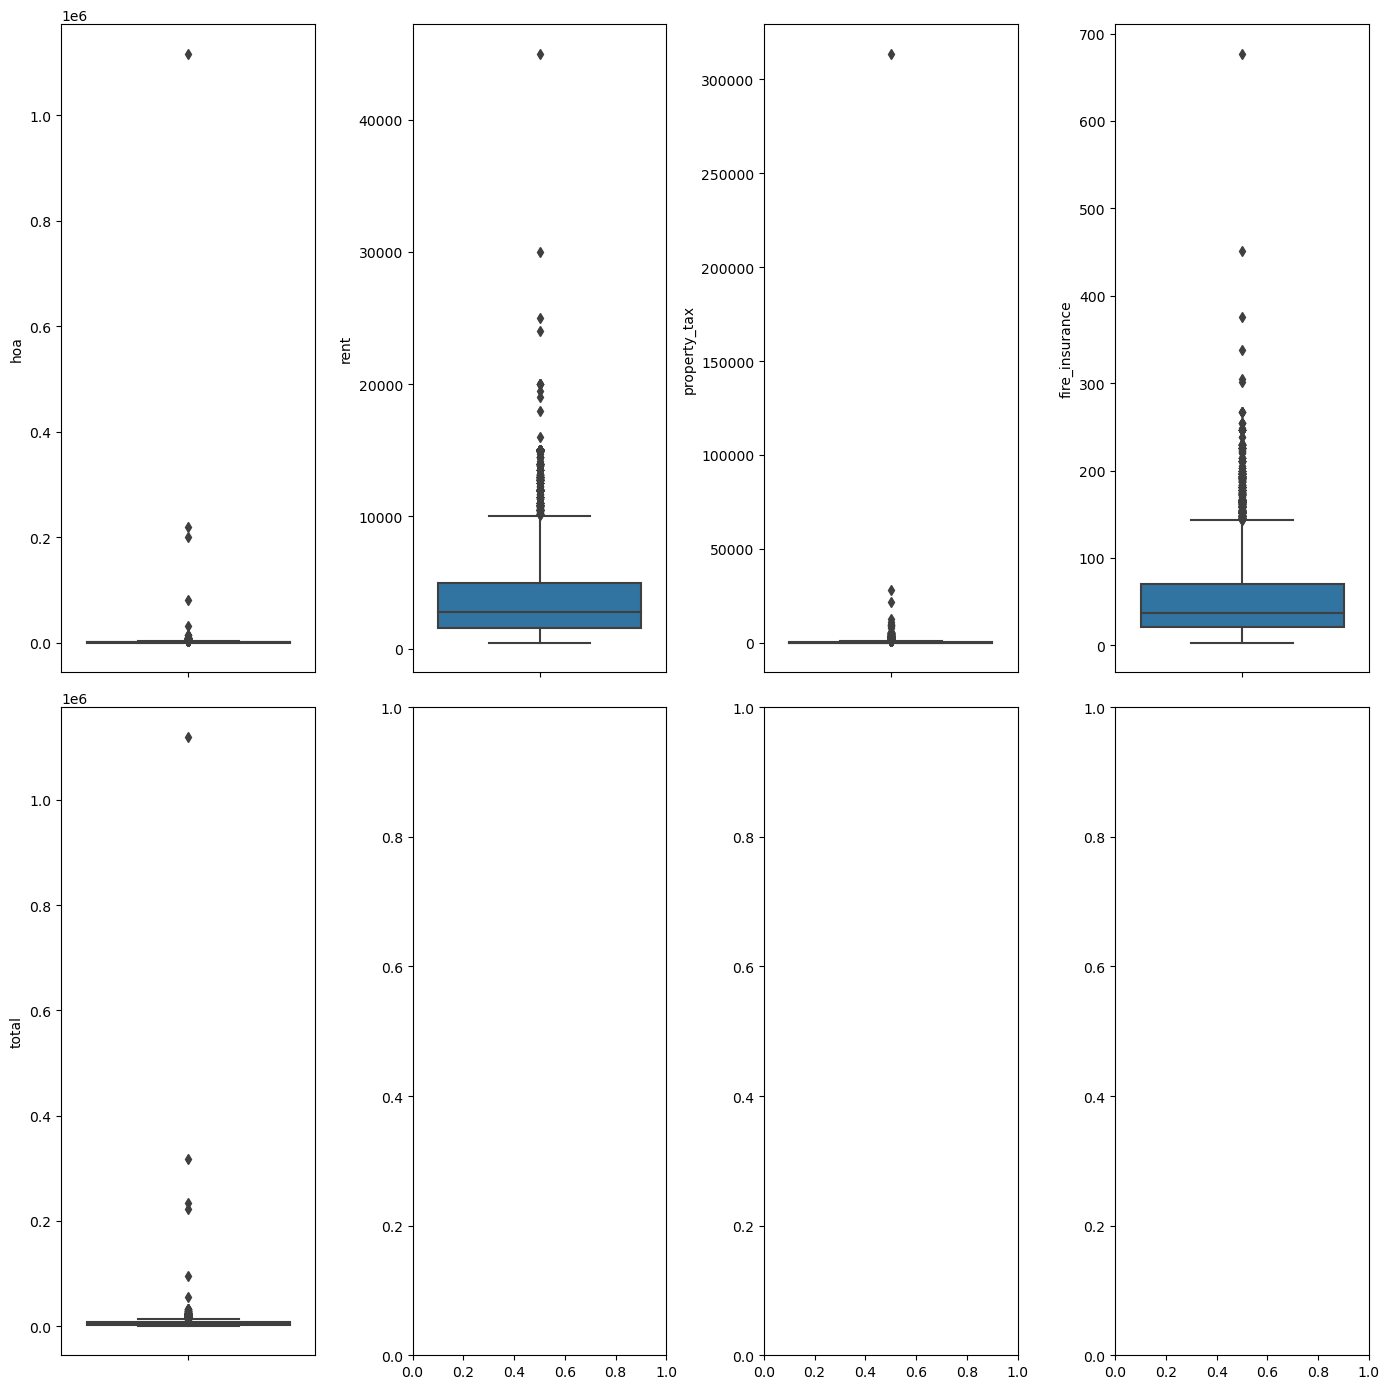

In [483]:
variaveis_numericas = []
for i in df.columns[0:13].tolist():
    if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
        print(i, ':', df.dtypes[i])
        variaveis_numericas.append(i)
plt.rcParams['figure.figsize'] = [14.00, 14.00]
plt.rcParams['figure.autolayout'] = True

plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 20

f, axes = plt.subplots(2,4) # 2 linhas e 4 colunas

linha = 0
coluna = 0

for i in variaveis_numericas:
    sns.boxplot(data = df, y=i, ax=axes[linha][coluna])
    coluna +=1
    if coluna == 4:
        linha += 1
        coluna = 0
plt.show()

In [484]:
# instanciando o objeto KNN
detector = KNN()

# treinando um detector de Outliers
detector.fit(df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [485]:
# labels_ retorno um array com 0 e 1
# 0 nao é outlier e 1 é outlier

previsoes = detector.labels_
previsoes

array([0, 1, 0, ..., 0, 1, 0])

In [486]:
# contagem para identificar oss outliers

np.unique(previsoes, return_counts=True)

(array([0, 1]), array([9300, 1034], dtype=int64))

In [487]:
# observando o calculo da distancia realizado para identificar outlier

confianca_previsao = detector.decision_scores_
confianca_previsao

array([ 234.95105873, 1005.547612  ,  141.5344481 , ...,  187.48333259,
        502.86081573,   95.53009997])

In [488]:
# criando lista somente com os outliers
outliers = []

for i in range(len(previsoes)):
    if previsoes[i] == 1:
        outliers.append(i)

In [489]:
lista_outliers = data.iloc[outliers,:]
lista_outliers

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent,property_tax,fire_insurance,total
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
7,São Paulo,213,4,4,4,4,acept,not furnished,2254,3223,1735,41,7253
8,São Paulo,152,2,2,1,3,acept,furnished,1000,15000,250,191,16440
19,São Paulo,600,4,5,6,-,acept,not furnished,0,12000,9500,181,21680
40,São Paulo,300,4,6,4,20,acept,not furnished,3700,12000,1584,153,17440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,São Paulo,141,3,5,0,4,acept,not furnished,909,10140,772,129,11950
10681,São Paulo,230,3,5,3,3,not acept,not furnished,3800,11000,1100,140,16040
10683,São Paulo,280,4,4,2,5,acept,not furnished,4200,4000,1042,51,9293
10686,São Paulo,150,3,3,2,8,not acept,furnished,0,13500,0,172,13670


In [490]:
lista_outliers.shape

(1034, 13)

In [491]:
data.shape

(10334, 13)

In [492]:
data.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa,rent,property_tax,fire_insurance,total
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [499]:
dfa = data.drop(lista_outliers)


KeyError: "['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'animal', 'furniture', 'hoa', 'rent', 'property_tax', 'fire_insurance', 'total'] not found in axis"

In [495]:
# verificando a variavel animal

data['animal'].value_counts()

acept        8076
not acept    2258
Name: animal, dtype: int64

In [496]:
# media de preço onde possui e nao possui animais

data.groupby('animal')['rent'].median()

animal
acept        2800.0
not acept    2500.0
Name: rent, dtype: float64

- São Paulo possui mais casas disponiveis para alugar,